In [16]:
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd as ag

In [17]:
minist_train = gluon.data.vision.FashionMNIST(train=True)
minist_test = gluon.data.vision.FashionMNIST(train=False)

def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')

# could be put inside the FashionMINIST() parameters list
minist_train = minist_train.transform(transform, lazy=True)
minist_test = minist_test.transform(transform, lazy=True)


In [18]:
import matplotlib.pyplot as plt

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

def show_images(images, labels):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15,15),
                          subplot_kw={'xticks': [], 'yticks': []})
    text_labels = get_text_labels(labels)
    for fig, image, text_label in zip(figs, images, text_labels):
        fig.imshow(image.reshape(image.shape[:2]).asnumpy())
        fig.set_title(text_label)
    plt.show()



In [19]:
batch_size = 256
train_data = gluon.data.DataLoader(minist_train, batch_size,shuffle=True)
test_data = gluon.data.DataLoader(minist_test, batch_size, shuffle=False)

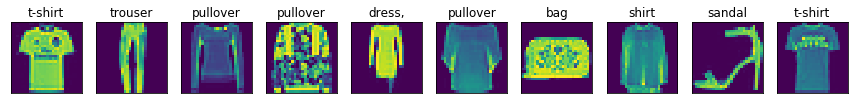

In [20]:
datas_to_show, labels_to_show = minist_test[:10]

show_images(datas_to_show, labels_to_show)

In [21]:
num_imputs = 28 * 28
num_outputs = 10

W = nd.random_normal(shape=(num_imputs, num_outputs))
b = nd.random_normal(shape=num_outputs)
params = [W, b]

for param in params:
    param.attach_grad()

In [22]:
def softmax(_yhat):
    exp = nd.exp(_yhat)
#     print("exp:  ", exp)
    partition = nd.sum(exp, axis=1, keepdims=True)
#     print('\npartition:  ;', partition)
    return nd.divide(exp, partition)

In [23]:
# play with axis sum
a = nd.array([[[1,0,0,2],[1,0,0,2], [3,0,0,3]],[[50,0,0,2],[5,0,0,5], [3,3,0,0]]])
print(nd.sum(a, axis=0).shape)
nd.sum(a, axis=1)

(3, 4)



[[ 5.  0.  0.  7.]
 [58.  3.  0.  7.]]
<NDArray 2x4 @cpu(0)>

In [24]:
def net(X):
    _yhat = nd.dot(X.reshape(-1, num_imputs), W) + b
    return softmax(_yhat)


In [25]:
def loss_CE(yhat, y):
    return - nd.pick(nd.log(yhat), y, axis=1)

In [26]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [27]:
def accuracy(yhat, labels):
    return nd.mean(yhat.argmax(axis=1) == labels).asscalar()
def evaluate_accuracy(data_iter, net):
    count = 0
    _accuracy = 0
    for datas, labels in data_iter:
        yhat = net(datas)
        _accuracy += accuracy(yhat, labels)
        count += 1
    return _accuracy / count


In [28]:
lr = 0.1 /256
lr

0.000390625

In [29]:
# net intialized but without trained
evaluate_accuracy(minist_test, net)

0.114

In [30]:
epochs = 5 
learning_rate = 0.00001 # attention! tricky here. gradient vanishing. 时灵时不灵，完全玄学！
print(evaluate_accuracy(test_data, net))
for e in range(epochs):
    total_loss = 0
    for datas, labels in train_data:
        y = labels
        with ag.record():
            yhat = net(datas)
            loss = loss_CE(yhat, y)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += loss.sum().asscalar()
#         print('epoch %d:total_loss inside batch:\t%f, accuracy inside batch:\t%f'% (e, loss.sum().asscalar(), accuracy(yhat, labels)))
#         print("gradient is :", params[0])
    print('\n Epoch %d finished!\nTotal loss: %f\t: The accuracy in test case:\t%f' % (e, total_loss, evaluate_accuracy(test_data, net)))

0.1142578125

 Epoch 0 finished!
Total loss: 661751.022705	: The accuracy in test case:	0.166992

 Epoch 1 finished!
Total loss: 447949.511230	: The accuracy in test case:	0.231152

 Epoch 2 finished!
Total loss: 348438.238892	: The accuracy in test case:	0.273242

 Epoch 3 finished!
Total loss: 296937.574921	: The accuracy in test case:	0.307910

 Epoch 4 finished!
Total loss: 270723.555939	: The accuracy in test case:	0.336230
